In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np


In [6]:
df = pd.read_csv("../data/data.csv")

In [7]:
df.shape

(14583, 3)

In [8]:
df.head

<bound method NDFrame.head of        ir_L  ir_R  degree
0       6.2  23.3    7.63
1       3.8  40.0    7.58
2       3.0  72.8    7.56
3       3.0  63.1    7.57
4       3.0  69.3    7.56
...     ...   ...     ...
14578  80.4  13.2   16.84
14579  82.1  12.8   17.68
14580  84.5  12.3   17.64
14581  85.4  12.1   17.65
14582  91.2  11.3   17.74

[14583 rows x 3 columns]>

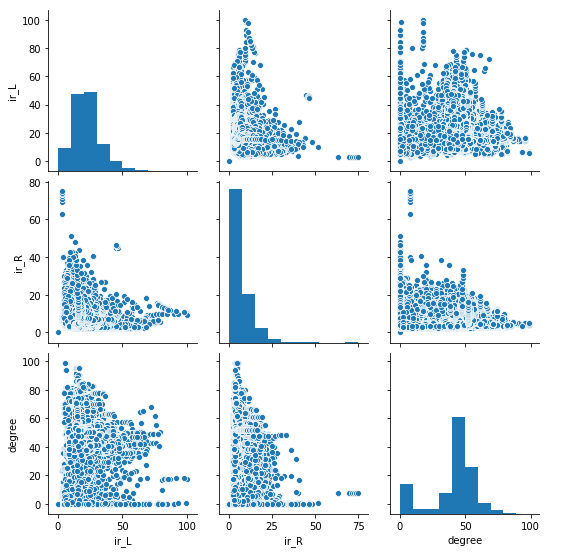

In [9]:
sns.pairplot(df, diag_kind='hist')

plt.show()

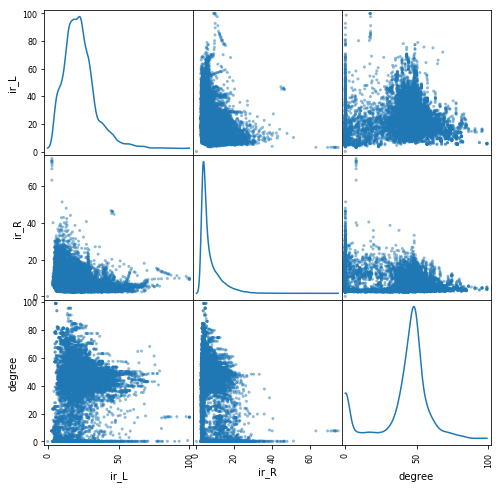

In [10]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Normalization

In [11]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(df)
df_n = pd.DataFrame(scaler.transform(df),columns=['ir_L', 'ir_R', 'degree'])

In [12]:
df_n

,ir_L,ir_R,degree
0,0.062,0.311081,0.077094
1,0.038,0.534045,0.076589
2,0.030,0.971963,0.076387
3,0.030,0.842457,0.076488
4,0.030,0.925234,0.076387
...,...,...,...
14578,0.804,0.176235,0.170153
14579,0.821,0.170895,0.178640
14580,0.845,0.164219,0.178236
14581,0.854,0.161549,0.178337


# Split data

In [32]:
# Original Data
df_inputs = df.loc[:,['ir_L', 'ir_R']]
df_outputs = df.loc[:,['degree']]

# Normalized Data
# df_inputs = df_n.loc[:,['ir_L', 'ir_R']]
# df_outputs = df_n.loc[:,['degree']]

inputs = np.array(df_inputs)
outputs = np.array(df_outputs)

In [33]:
num_data = len(inputs)
TRAIN_SPLIT = int(0.6 * num_data)
TEST_SPLIT = int(0.2 * num_data + TRAIN_SPLIT)

In [34]:
inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

# Multiple Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(inputs_train, outputs_train)

LinearRegression()

In [24]:
# The coefficients
print('Coefficients: \n', mlr.coef_)

# mean square error
print("RSS: %.2f" % np.mean((mlr.predict(inputs_test) - outputs_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % mlr.score(inputs_test, outputs_test))

Coefficients: 
 [[ 0.13601025 -0.96831075]]
RSS: 0.03
Variance score: 0.16


In [25]:
outputs_predict = mlr.predict(inputs_test)

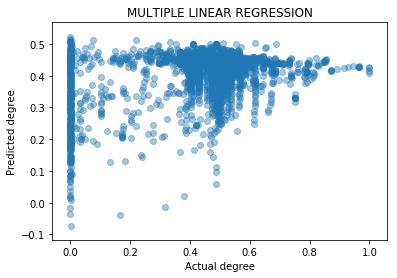

In [26]:
plt.scatter(outputs_test, outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

# DNN

In [35]:
import tensorflow as tf

In [57]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = inputs_train.shape[1]))
model.add(tf.keras.layers.Dense(50, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.2))
model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.2))

model.add(tf.keras.layers.Dense(1, activation='relu'))



# model.compile(optimizer='adam', loss='mae', metrics=['mae']) # mse / mae
model.compile(optimizer='adam', loss='mse', metrics=['mse']) # mse / mae
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 671
Trainable params: 671
Non-trainable params: 0
_________________________________________________________________


In [67]:
history = model.fit(inputs_train, outputs_train, epochs=1, batch_size=1000, validation_data=(inputs_validate, outputs_validate))

Train on 8749 samples, validate on 2918 samples
8749/8749 [==============================] - 0s 15us/sample - loss: 238.3560 - mean_squared_error: 238.3560 - val_loss: 257.4993 - val_mean_squared_error: 257.4993


In [68]:
outputs_predict = model.predict(inputs_test)

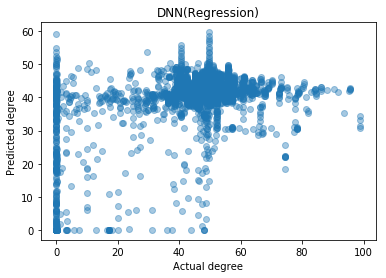

In [69]:
plt.scatter(outputs_test, outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("DNN(Regression)")
plt.show()

# Feature 추가(mot_L, mot_R)

In [70]:
def chdeg(degree_original):
    degree = ((degree_original - 50)*1.5)//1
    if degree <= 0:
        left = 25
        right = 25 + abs(degree)
    else:
        left = 25 - abs(degree)
        right = 25
    return left, right

left = []
right = []
for i in range(len(df)):
    left.append(chdeg(df['degree'][i])[0])
    right.append(chdeg(df['degree'][i])[1])
    
df['mot_L'] = left
df['mot_R'] = right

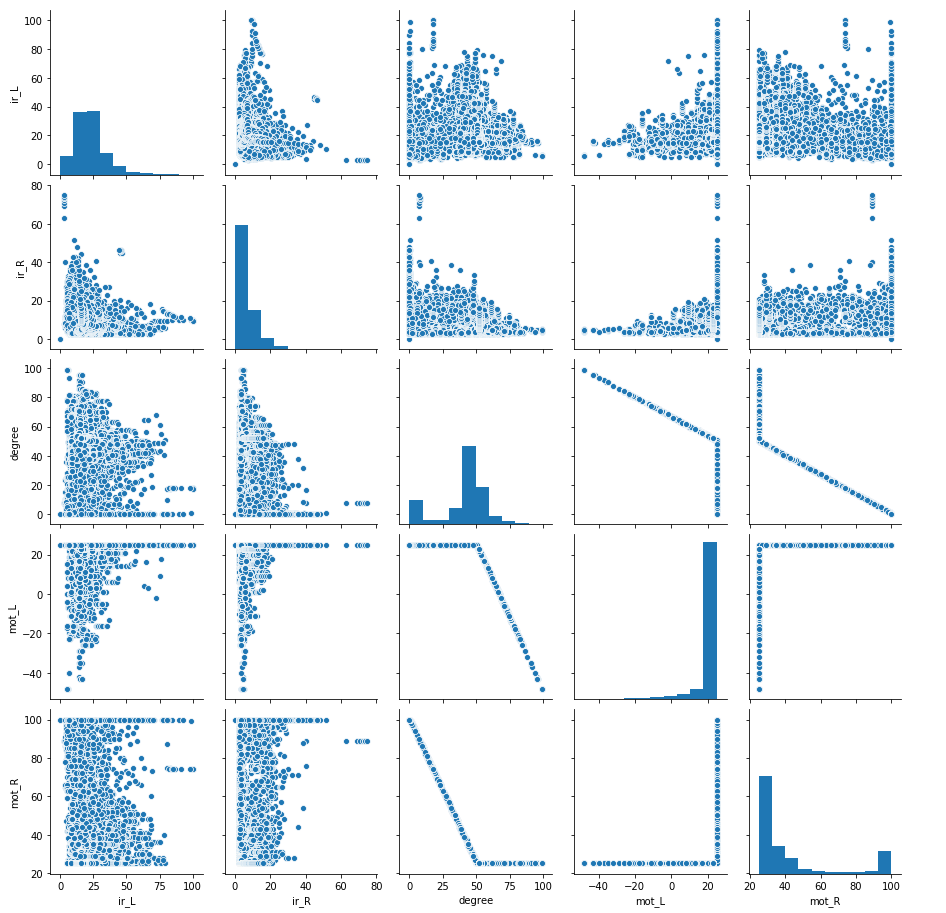

In [71]:
sns.pairplot(df, diag_kind='hist')

plt.show()

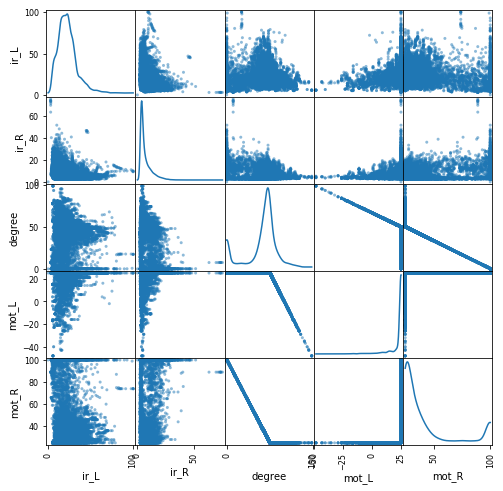

In [72]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Feature 추가(ir distance 차이, 비율)

### ir 좌우 차이

In [73]:
df['ir_R-L'] = df['ir_R'] - df['ir_L']
df['ir_L/R'] = df['ir_L'] / df['ir_R'] 
df

,ir_L,ir_R,degree,mot_L,mot_R,ir_R-L,ir_L/R
0,6.2,23.3,7.63,25.0,89.0,17.1,0.266094
1,3.8,40.0,7.58,25.0,89.0,36.2,0.095000
2,3.0,72.8,7.56,25.0,89.0,69.8,0.041209
3,3.0,63.1,7.57,25.0,89.0,60.1,0.047544
4,3.0,69.3,7.56,25.0,89.0,66.3,0.043290
...,...,...,...,...,...,...,...
14578,80.4,13.2,16.84,25.0,75.0,-67.2,6.090909
14579,82.1,12.8,17.68,25.0,74.0,-69.3,6.414062
14580,84.5,12.3,17.64,25.0,74.0,-72.2,6.869919
14581,85.4,12.1,17.65,25.0,74.0,-73.3,7.057851


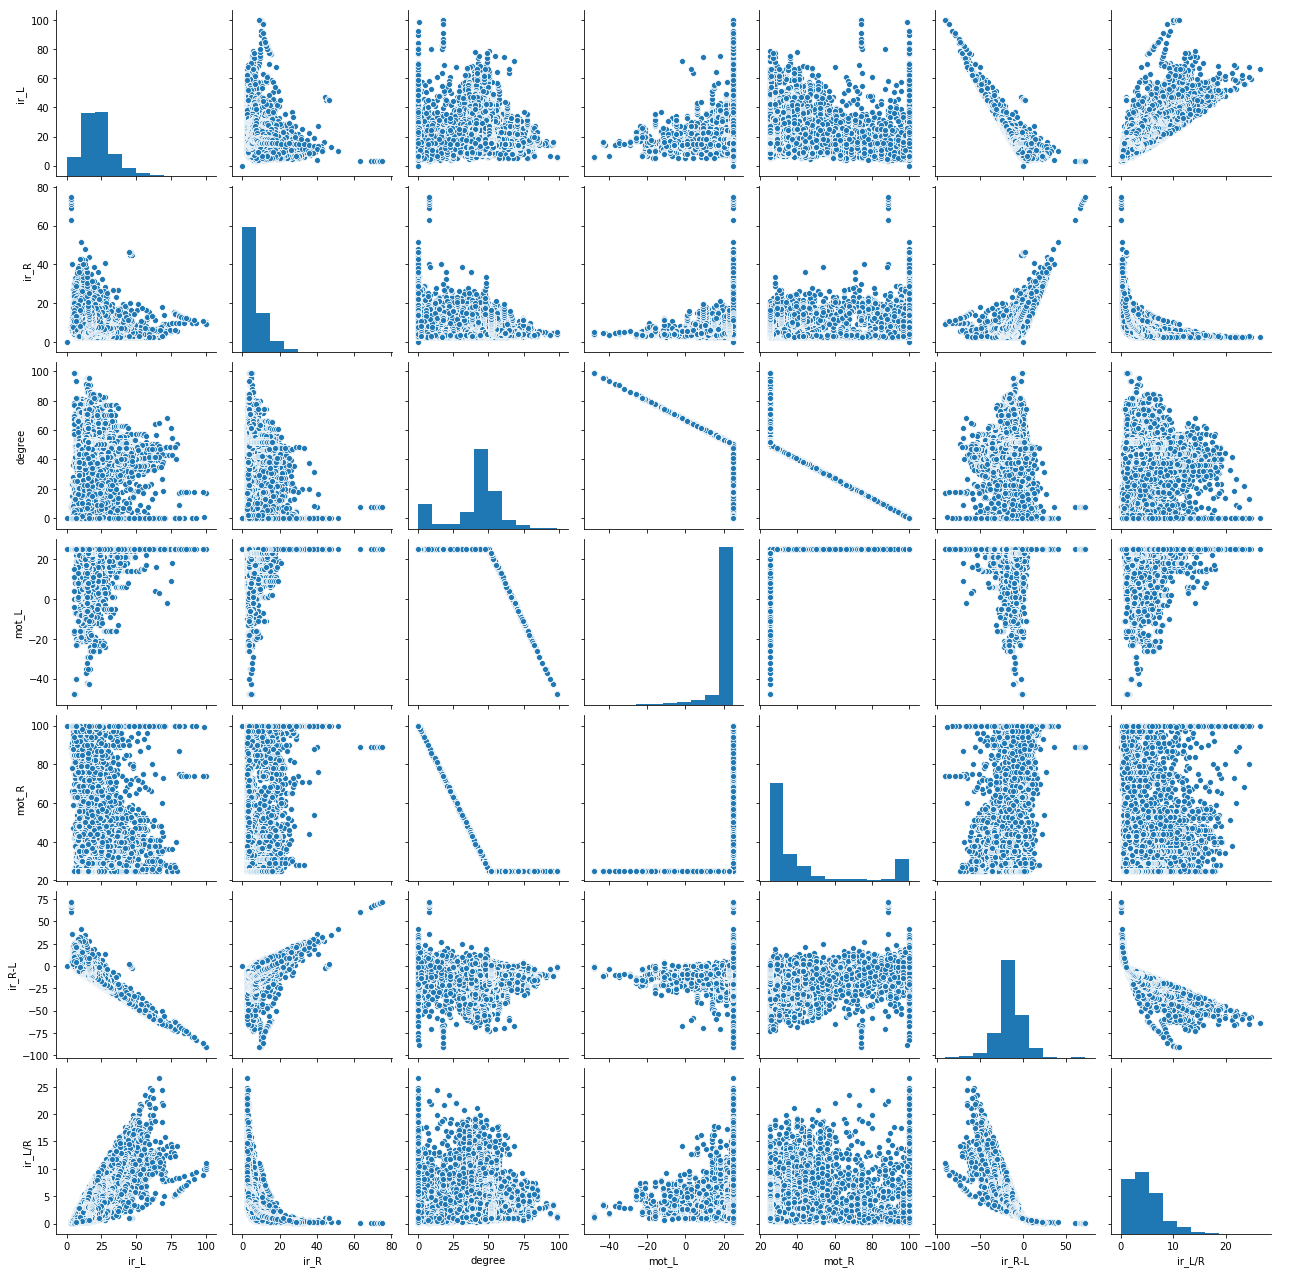

In [74]:
sns.pairplot(df, diag_kind='hist')

plt.show()

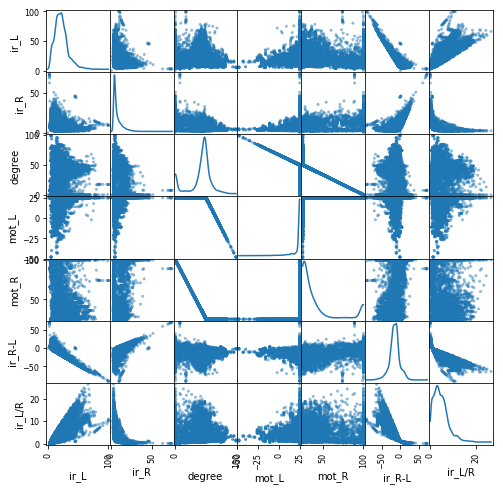

In [75]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Except degree under 10 over 90 data

In [ ]:
df.sort_values(by=['degree'])

In [ ]:
df_s = df.loc[(10 < df['degree']) & (df['degree'] < 90), : ]

In [ ]:
sns.pairplot(df_s, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df_s, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# exclude degree over 50

In [ ]:
df_d = df.loc[df['degree'] < 50, : ]
df_d

In [ ]:
sns.pairplot(df_d, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df_d, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Time stamp 설정

In [41]:
# Time Stamp를 지정하여 그 안의 값들에 대해 대표값으로 데이터를 구성
# 대표값은 평균(averave), 중앙값(median), 최빈값(mode) 중 평균값과 중앙값을 우선적으로 테스트한다.

In [76]:
df

,ir_L,ir_R,degree,mot_L,mot_R,ir_R-L,ir_L/R
0,6.2,23.3,7.63,25.0,89.0,17.1,0.266094
1,3.8,40.0,7.58,25.0,89.0,36.2,0.095000
2,3.0,72.8,7.56,25.0,89.0,69.8,0.041209
3,3.0,63.1,7.57,25.0,89.0,60.1,0.047544
4,3.0,69.3,7.56,25.0,89.0,66.3,0.043290
...,...,...,...,...,...,...,...
14578,80.4,13.2,16.84,25.0,75.0,-67.2,6.090909
14579,82.1,12.8,17.68,25.0,74.0,-69.3,6.414062
14580,84.5,12.3,17.64,25.0,74.0,-72.2,6.869919
14581,85.4,12.1,17.65,25.0,74.0,-73.3,7.057851


In [122]:
frame = 5
length = len(df)
df_frame = pd.DataFrame(columns=['ir_L', 'ir_R', 'degree', 'mot_L', 'mot_R', 'ir_R-L', 'ir_L/R'])
ir_L, ir_R, degree, mot_L, mot_R, ir_RL, ir_LR = [], [], [], [], [], [], []

for i in range(length//frame):
    a = i*frame
    b = (i+1)*frame
    ir_L.append(np.median(df['ir_L'][a:b]))
    ir_R.append(np.median(df['ir_R'][a:b]))
    degree.append(np.median(df['degree'][a:b]))
    mot_L.append(np.median(df['mot_L'][a:b]))
    mot_R.append(np.median(df['mot_R'][a:b]))
    ir_RL.append(np.median(df['ir_R-L'][a:b]))
    ir_LR.append(np.median(df['ir_L/R'][a:b]))
df_frame['ir_L'] = ir_L
df_frame['ir_R'] = ir_R
df_frame['degree'] = degree
df_frame['mot_L'] = mot_L
df_frame['mot_R'] = mot_R
df_frame['ir_R-L'] = ir_RL
df_frame['ir_L/R'] = ir_LR

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [123]:
df_frame

,ir_L,ir_R,degree,mot_L,mot_R,ir_R-L,ir_L/R
0,3.0,63.1,7.57,25.0,89.0,60.1,0.047544
1,3.1,73.3,7.59,25.0,89.0,70.2,0.042292
2,17.6,2.9,50.70,24.0,25.0,-14.7,6.068966
3,18.2,2.7,51.56,23.0,25.0,-15.4,6.666667
4,19.3,2.7,49.60,25.0,26.0,-16.6,7.111111
...,...,...,...,...,...,...,...
2911,15.7,14.3,51.90,23.0,25.0,-1.4,1.097902
2912,15.1,20.7,27.32,25.0,60.0,5.6,0.729469
2913,6.8,29.5,0.05,25.0,100.0,23.3,0.222951
2914,36.7,16.3,0.05,25.0,100.0,-20.4,2.251534


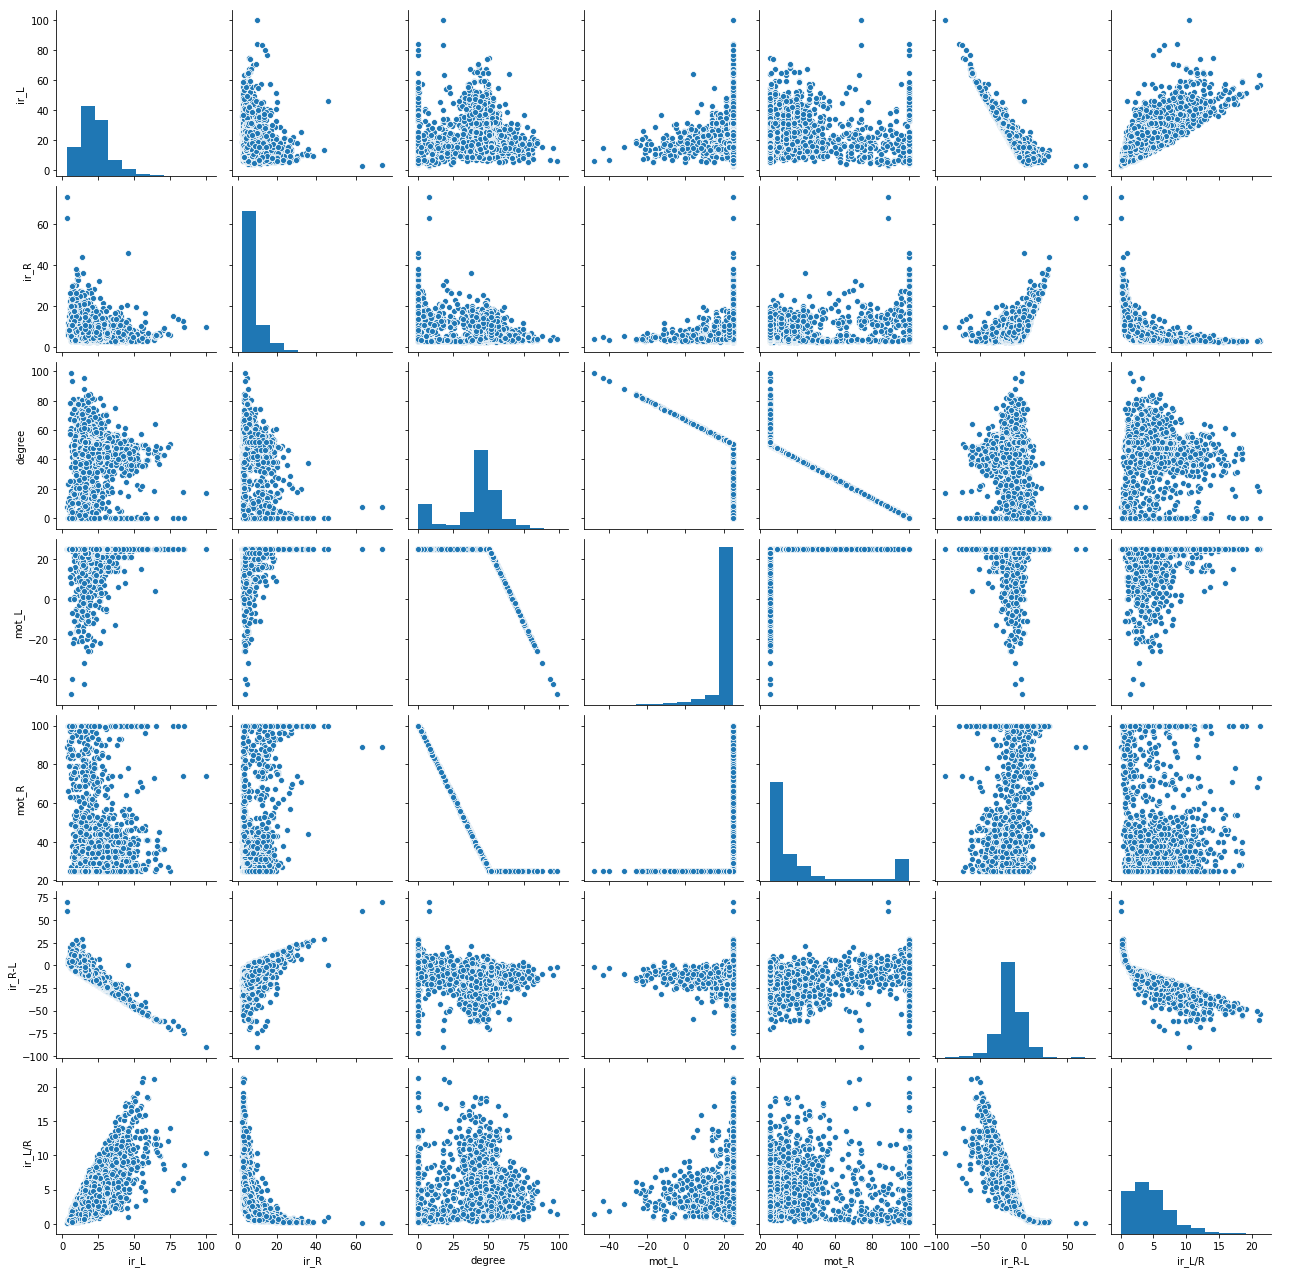

In [124]:
sns.pairplot(df_frame, diag_kind='hist')

plt.show()

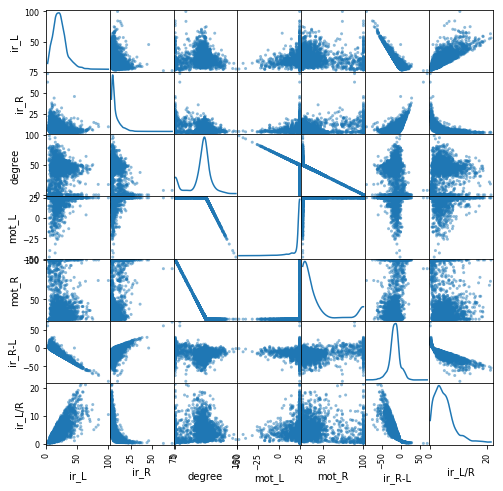

In [125]:
scatter_matrix(df_frame, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

In [126]:
import tensorflow as tf

# Original Data
df_inputs = df_frame.loc[:,['ir_L', 'ir_R', 'ir_R-L', 'ir_L/R']]
df_outputs = df_frame.loc[:,['degree']]

# Normalized Data
# df_inputs = df_n.loc[:,['ir_L', 'ir_R']]
# df_outputs = df_n.loc[:,['degree']]

inputs = np.array(df_inputs)
outputs = np.array(df_outputs)

num_data = len(inputs)
TRAIN_SPLIT = int(0.6 * num_data)
TEST_SPLIT = int(0.2 * num_data + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])



model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = inputs_train.shape[1]))
model.add(tf.keras.layers.Dense(50, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.2))
# model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.2))

model.add(tf.keras.layers.Dense(1, activation='relu'))



# model.compile(optimizer='adam', loss='mae', metrics=['mae']) # mse / mae
model.compile(optimizer='adam', loss='mse', metrics=['mse']) # mse / mae
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 50)                250       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 51        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [127]:
history = model.fit(inputs_train, outputs_train, epochs=1, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Train on 1749 samples, validate on 584 samples
1749/1749 [==============================] - 8s 5ms/sample - loss: 580.4194 - mean_squared_error: 580.4189 - val_loss: nan - val_mean_squared_error: nan


In [128]:
outputs_predict = model.predict(inputs_test)

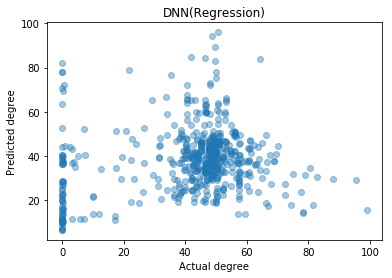

In [131]:
plt.scatter(outputs_test, outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("DNN(Regression)")
plt.show()

In [133]:
ir_L = 18.8
ir_R = 2.7
ir_RL = ir_R - ir_L
ir_LR = ir_L / ir_R
data = [ir_L, ir_R, ir_RL, ir_LR]
data

[18.8, 2.7, -16.1, 6.962962962962963]

In [138]:
model.predict([[data]])

array([[32.805603]], dtype=float32)

In [139]:
from train import Model

In [141]:
m = Model()
dataframe = pd.read_csv("../data/data.csv")
m.set_data(dataframe)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'